In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import wandb
wandb.init(name='CNN-Single-Layer', project='FMNIST', tags=['DNN'])
config = wandb.config

Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' returned non-zero exit status 128.


## Data

In [2]:
import sys; sys.path.append('/home/yyr/data/FMNIST/')
from load_fmnist import *

2020-01-06 13:21:14.189 | INFO     | load_fmnist:<module>:20 - Loaded the variables - [] into environment


tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_images & val_targets:
	X - torch.Size([10000, 28, 28])
	Y - torch.Size([10000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


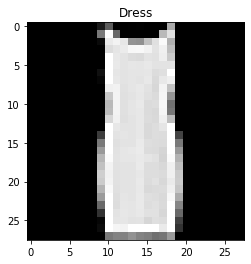

In [3]:
ix = np.random.randint(len(tr_images))
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]]);

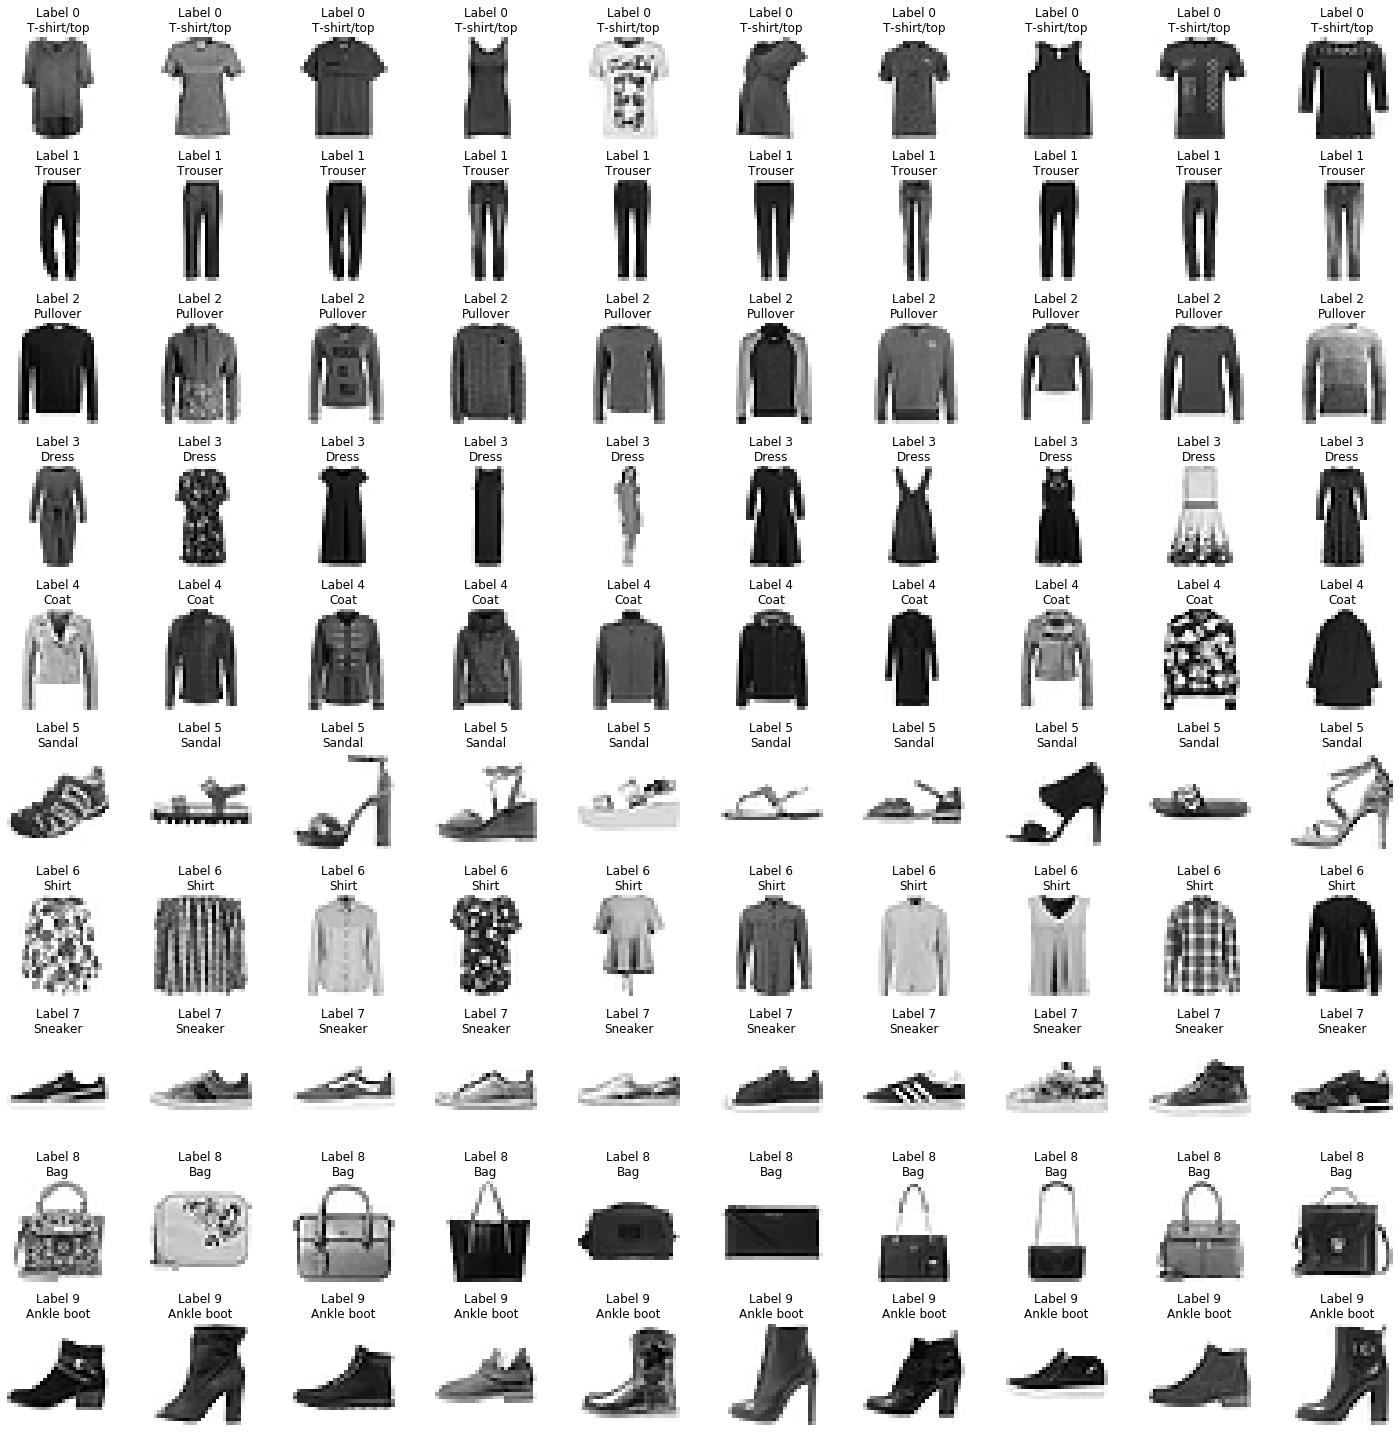

In [4]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(20,20))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray_r')
        plot_cell.set_title(f'Label {y}\n{fmnist.classes[y]}')
plt.tight_layout()

### Data Loaders

In [5]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y): self.x, self.y = x, y
    def __getitem__(self, ix):
        x, y = self.x[ix]/255., self.y[ix]
        return x.to(device)[None], y.to(device)
    def __len__(self): return len(self.x)

def get_data(NORMALIZATION):
    if not NORMALIZATION:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        train = TensorDataset(tr_images.float().to(device), tr_targets.to(device))
        val = TensorDataset(val_images.float().to(device), val_targets.to(device))
        print(f'Train:\t{len(train)} images\nVal:\t{len(val)} images')

        trn_dl = DataLoader(train, batch_size=32, shuffle=True)
        val_dl = DataLoader(val, batch_size=32, shuffle=False)

    else:
        train = FMNISTDataset(tr_images, tr_targets)
        val = FMNISTDataset(val_images, val_targets)
        
        trn_dl = DataLoader(train, batch_size=32, shuffle=True)
        val_dl = DataLoader(val, batch_size=32, shuffle=False)
    return trn_dl, val_dl

## Architecture, Loss and Optimizer

In [6]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(1690, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
              ReLU-3           [-1, 10, 13, 13]               0
           Flatten-4                 [-1, 1690]               0
            Linear-5                  [-1, 256]         432,896
              ReLU-6                  [-1, 256]               0
            Linear-7                   [-1, 10]           2,570
Total params: 435,566
Trainable params: 435,566
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.09
Params size (MB): 1.66
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


## Training Loop

In [7]:
def train_batch(x, y, model, opt, loss_fn):
    'call your model like any python function on your batch of inputs'
    prediction = model(x)
    is_correct = prediction.max(-1)[1] == y
    'compute loss'
    batch_loss = loss_fn(prediction, y)
    'based on the forward pass in `model(x)` compute all the gradients of `model.parameters()`'
    batch_loss.backward()
    'apply new-weights = f(old-weights, old-weight-gradients) where "f" is the optimizer.'
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct
def validate_batch(x, y, model, loss_fn):
    'just do a forward pass and store the losses for the entire batch'
    prediction = model(x)
    'compute if the location of maximum in each row coincides with ground truth'
    is_correct = prediction.max(-1)[1] == y
    batch_loss = loss_fn(prediction, y)
    return batch_loss.item(), is_correct

In [8]:
import time, dill
trn_dl, val_dl = get_data(NORMALIZATION=True)

model, loss_fn, optimizer = get_model()
wandb.watch(model, log='all')

best_val_acc = -1
for epoch in range(10):
    start = time.time()
    N_trn = len(trn_dl)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss, corrects = train_batch(x, y, model, optimizer, loss_fn)
        train_losses.append(batch_loss)
        train_acc.extend(corrects.tolist())
        print(f'{ix}/{N_trn}, Loss: {batch_loss:.3f}', end='\r')

    N_val = len(val_dl)
    for ix, batch in enumerate(val_dl):
        print(f'Testing {ix}/{N_val}', end='\r')
        x, y = batch
        batch_loss, corrects = validate_batch(x, y, model, loss_fn)
        val_losses.append(batch_loss)
        val_acc.extend(corrects.tolist())
        
    wandb.log({'train_loss': np.mean(train_losses), 
               'valid_loss': np.mean(val_losses), 
               'train_acc': np.mean(train_acc),
               'valid_acc': np.mean(val_acc)})
    
    print(f'Epoch: {epoch+1:3d}, Train Loss: {np.mean(train_losses):.3f}, Validation Loss: {np.mean(val_losses):.3f}, Train Acc: {np.mean(train_acc)*100:.2f}%, Validation Acc: {np.mean(val_acc)*100:.2f}% Time: {time.time()-start:.0f} seconds')


Error generating diff: Command '['git', 'diff', '--submodule=diff', 'HEAD']' returned non-zero exit status 128.


Epoch:   1, Train Loss: 0.438, Validation Loss: 0.350, Train Acc: 84.30%, Validation Acc: 87.40% Time: 9 seconds
Epoch:   2, Train Loss: 0.295, Validation Loss: 0.314, Train Acc: 89.28%, Validation Acc: 88.82% Time: 8 seconds
Epoch:   3, Train Loss: 0.248, Validation Loss: 0.273, Train Acc: 90.91%, Validation Acc: 90.12% Time: 8 seconds
Epoch:   4, Train Loss: 0.214, Validation Loss: 0.273, Train Acc: 92.19%, Validation Acc: 90.17% Time: 8 seconds
Epoch:   5, Train Loss: 0.187, Validation Loss: 0.268, Train Acc: 93.05%, Validation Acc: 90.75% Time: 7 seconds
Epoch:   6, Train Loss: 0.162, Validation Loss: 0.254, Train Acc: 94.14%, Validation Acc: 91.35% Time: 8 seconds
Epoch:   7, Train Loss: 0.141, Validation Loss: 0.271, Train Acc: 94.87%, Validation Acc: 91.17% Time: 8 seconds
Epoch:   8, Train Loss: 0.123, Validation Loss: 0.258, Train Acc: 95.49%, Validation Acc: 91.69% Time: 7 seconds
Epoch:   9, Train Loss: 0.105, Validation Loss: 0.279, Train Acc: 96.14%, Validation Acc: 91.54%

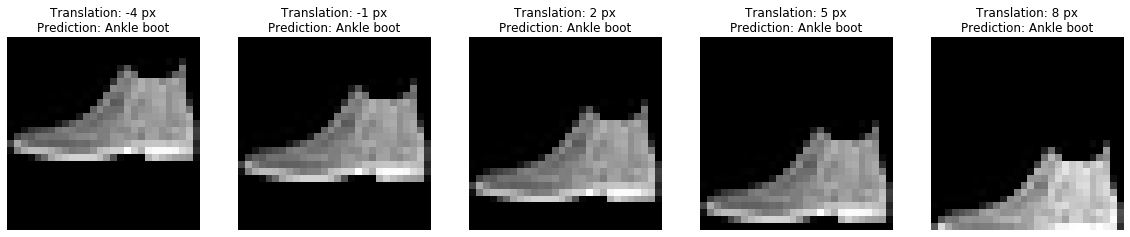

In [66]:
import imgaug as ia
from imgaug import augmenters as iaa
import sys; sys.path.append('/home/yyr/')
from python_utilities.loader import show
    
tfm = lambda translate_px: iaa.Sequential([
    iaa.Affine(translate_px={'y': translate_px})
])

im = val_images[0].numpy()
fig, ax = plt.subplots(1, 5, figsize=(20,4))
for ix, px in enumerate(range(-4, 9, 3)):
    tfm_ = tfm(px)
    translated_image = tfm_.augment_image(im)
    pred = model(torch.tensor(translated_image)[None,None].float().to(device))[0]
    _, argmax = pred.max(0)
    info = f'Translation: {px} px\nPrediction: {fmnist.classes[argmax]}'
    show(translated_image, ax=ax[ix], title=info)
